In [68]:
#install unzip in notebook
!sudo apt-get install -y unzip zip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unzip zip
0 upgraded, 2 newly installed, 0 to remove and 50 not upgraded.
Need to get 335 kB of archives.
After this operation, 1231 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 unzip amd64 6.0-25ubuntu1.1 [168 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 zip amd64 3.0-11build1 [167 kB]
Fetched 335 kB in 0s (2045 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 25583 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-25ubuntu1.1_amd64.deb ...
Unpacking unzip (6.0-25ubuntu1.1) ...
Selecting previously unselected package zip.
Preparing to unpack .../zip_3.0-11build1_amd64.deb ...
Unpacking zip (3.0-11build1) ...
Setting up unzip (6.0-25ubuntu1.1) 

In [69]:
!pip install boto3 datasets


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [70]:
import boto3

s3 = boto3.resource('s3', endpoint_url='https://storage.s3.mlops.wogra.com')
bucket = s3.Bucket('data')

In [71]:
bucket.download_file('dlr/dataset_tapelegen.zip', 'data.zip')

In [72]:
# extreact zip file to data folder
!rm -r data
!unzip data.zip -d data

Archive:  data.zip
   creating: data/dataset_tapelegen/
  inflating: data/dataset_tapelegen/dataset_info.json  
  inflating: data/dataset_tapelegen/data-00001-of-00003.arrow  
  inflating: data/dataset_tapelegen/state.json  
  inflating: data/dataset_tapelegen/data-00000-of-00003.arrow  
  inflating: data/dataset_tapelegen/data-00002-of-00003.arrow  
 extracting: data/dataset_tapelegen/dataset_dict.json  
   creating: data/dataset_tapelegen/train/
  inflating: data/dataset_tapelegen/train/dataset_info.json  
  inflating: data/dataset_tapelegen/train/data-00001-of-00003.arrow  
  inflating: data/dataset_tapelegen/train/state.json  
  inflating: data/dataset_tapelegen/train/data-00000-of-00003.arrow  
  inflating: data/dataset_tapelegen/train/data-00002-of-00003.arrow  


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 50.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 7.0.0
    Uninstalling pyarrow-7.0.0:
      Successfully uninstalled pyarrow-7.0.0

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
# create a dataset for images in the folders and use the folder name as label
from datasets import load_from_disk

dataset = load_from_disk("data/dataset_tapelegen/")

# take random seed of examples from dataset
dataset = dataset.shuffle(seed=42)
dataset


/home/ray/anaconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading cached shuffled indices for dataset at /home/jovyan/work/data/dataset_tapelegen/cache-fffa42af9c821476.arrow


Dataset({
    features: ['image', 'label'],
    num_rows: 73749
})

In [2]:
# remove all items from dataset with mean 0 but dont use remove rows which not exists as method
import numpy as np
clean_dataset = dataset.filter(lambda example: np.mean(example["image"]) != 0)

Loading cached processed dataset at /home/jovyan/work/data/dataset_tapelegen/cache-2ec92fc4d37af4eb.arrow


In [3]:
clean_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 72287
})

In [4]:
!pip install transformers==4.26.1 evaluate


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [5]:
import transformers

checkpoint = "google/vit-base-patch16-224-in21k"

feature_extractor = transformers.AutoFeatureExtractor.from_pretrained(
    checkpoint
)
print(feature_extractor.size)
print(feature_extractor.image_mean)
print(feature_extractor.image_std)

{'height': 224, 'width': 224}
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]


/home/ray/anaconda3/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:
from torchvision import transforms
import numpy as np

def preprocess(image):
    # convert image to tensor
    tensor = transforms.ToTensor()(image)
    tensor = tensor - np.mean(tensor.numpy()) + 128
    tensor[tensor < 0] = 0
    tensor[tensor > 255] = 255
    tensor = tensor / 255
    # repeat the tensor two ore times to get 3 channels and use the repeat function
    tensor = tensor.repeat(3, 1, 1)
    return tensor


class Preprocess:
    def __init__(self):
        self.transforms = transforms.Compose(
            [
                transforms.Lambda(preprocess),
                transforms.CenterCrop(224),
            ]
        )

    def __call__(self, example_batch):
        example_batch["pixel_values"] = [
            self.transforms(img) for img in example_batch["image"]
        ]
        del example_batch["image"]
        return example_batch
    
preprocessed_dataset = clean_dataset.with_transform(Preprocess())

In [7]:
labels = clean_dataset.features["label"].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [23]:
id2label

{'0': 'g', '1': 'n', '2': 'o'}

In [24]:
label2id

{'g': '0', 'n': '1', 'o': '2'}

In [27]:
labelids = [int(id) for id in id2label.keys()]

In [8]:

from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:

from transformers import TrainingArguments

batch_size = 14*16

training_args = TrainingArguments(
    output_dir="my_tapelegen_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [55]:
import evaluate
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [56]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

loading configuration file preprocessor_config.json from cache at /home/jovyan/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/preprocessor_config.json
loading configuration file config.json from cache at /home/jovyan/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.26.1"
}

size should be a dictionary on of the f

In [57]:
filtered_datasets = [preprocessed_dataset.filter(lambda example: example["label"] == labelid, batch_size=1024) for labelid in labelids]

Loading cached processed dataset at /home/jovyan/work/data/dataset_tapelegen/cache-dd0639771ed9fe29.arrow
Loading cached processed dataset at /home/jovyan/work/data/dataset_tapelegen/cache-7017c79504a484f1.arrow
Loading cached processed dataset at /home/jovyan/work/data/dataset_tapelegen/cache-75581852b42c631f.arrow


In [58]:
filtered_datasets[0]

Dataset({
    features: ['image', 'label'],
    num_rows: 8707
})

In [59]:
# get the minimum number of examples in the dataset with respect to the label
min_examples = min(data.num_rows for data in filtered_datasets)
min_examples

3248

In [60]:
from datasets import concatenate_datasets

weighted_dataset = concatenate_datasets(
    [
        fd.shuffle(seed=42).select(range(min_examples)) for fd in filtered_datasets
    ]  
)

Loading cached shuffled indices for dataset at /home/jovyan/work/data/dataset_tapelegen/cache-dceaf897d20241d8.arrow
Loading cached shuffled indices for dataset at /home/jovyan/work/data/dataset_tapelegen/cache-c1be13090c497e9c.arrow
Loading cached shuffled indices for dataset at /home/jovyan/work/data/dataset_tapelegen/cache-3004aaeff938c96f.arrow


In [61]:
weighted_dataset.num_rows - 3*min_examples

0

In [62]:
# 90% train, 10% test + validation
split_one = weighted_dataset.train_test_split(test_size=0.2)

In [63]:
# Split the 10% test + valid in half test, half valid
split_two = split_one['test'].train_test_split(test_size=0.5)

In [64]:
from datasets import DatasetDict

train_test_valid_dataset = DatasetDict({
    "train": split_one["train"],
    "validate": split_two["train"],
    "test": split_two["test"]})
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7795
    })
    validate: Dataset({
        features: ['image', 'label'],
        num_rows: 974
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 975
    })
})

In [65]:
model.to('cuda')

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [66]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_test_valid_dataset["train"],
    eval_dataset=train_test_valid_dataset["validate"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [67]:
trainer.train()

/home/ray/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7795
  Num Epochs = 10
  Instantaneous batch size per device = 224
  Total train batch size (w. parallel, distributed & accumulation) = 2688
  Gradient Accumulation steps = 4
  Total optimization steps = 30
  Number of trainable parameters = 85800963
/home/ray/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 974
  Batch size = 672
  Num examples = 974
  Batch size = 672
Saving model checkpoint to my_tapelegen_model/checkpoint-3
Configuration saved in my_tapelegen_model/checkpoint-3/config.json
Saving model checkpoint to my_tapelegen_model/checkpoint-3
Configuration saved in my_tapelegen_model/checkpoint-3/config.json
Model weights saved in my_tapelegen_model/checkpoint-3/pytorch_model.bin
Image processor saved in my_tapelegen_model/checkpoint-3/preprocessor_config.json
/home/ray/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 974
  Batch size = 672
Saving model checkpoint to my_tapelegen_model/checkpoint-6
Configuration saved in my_tapelegen_model/checkpoint-6/config.json
Mod

TrainOutput(global_step=30, training_loss=0.3588478406270345, metrics={'train_runtime': 407.783, 'train_samples_per_second': 191.156, 'train_steps_per_second': 0.074, 'total_flos': 6.040554729553613e+18, 'train_loss': 0.3588478406270345, 'epoch': 10.0})

In [68]:
trainer.state.log_history

[{'eval_loss': 0.6809923648834229,
  'eval_accuracy': 0.9229979466119097,
  'eval_runtime': 2.5281,
  'eval_samples_per_second': 385.268,
  'eval_steps_per_second': 0.791,
  'epoch': 1.0,
  'step': 3},
 {'eval_loss': 0.48242175579071045,
  'eval_accuracy': 0.9414784394250514,
  'eval_runtime': 2.7691,
  'eval_samples_per_second': 351.735,
  'eval_steps_per_second': 0.722,
  'epoch': 2.0,
  'step': 6},
 {'eval_loss': 0.3710828423500061,
  'eval_accuracy': 0.9425051334702259,
  'eval_runtime': 2.658,
  'eval_samples_per_second': 366.447,
  'eval_steps_per_second': 0.752,
  'epoch': 3.0,
  'step': 9},
 {'loss': 0.5878,
  'learning_rate': 3.7037037037037037e-05,
  'epoch': 3.33,
  'step': 10},
 {'eval_loss': 0.30819883942604065,
  'eval_accuracy': 0.944558521560575,
  'eval_runtime': 3.0359,
  'eval_samples_per_second': 320.832,
  'eval_steps_per_second': 0.659,
  'epoch': 4.0,
  'step': 12},
 {'eval_loss': 0.2719261646270752,
  'eval_accuracy': 0.9486652977412731,
  'eval_runtime': 2.7191

In [69]:
# iterate over the log history and collect the value eval_loss in a list if the key exists in the dict item
eval_loss = [item["eval_loss"] for item in trainer.state.log_history if "eval_loss" in item.keys()]

In [70]:
# now collect the accuracy in a list ehich has the key eval_accuracy
eval_accuracy = [item["eval_accuracy"] for item in trainer.state.log_history if "eval_accuracy" in item.keys()]

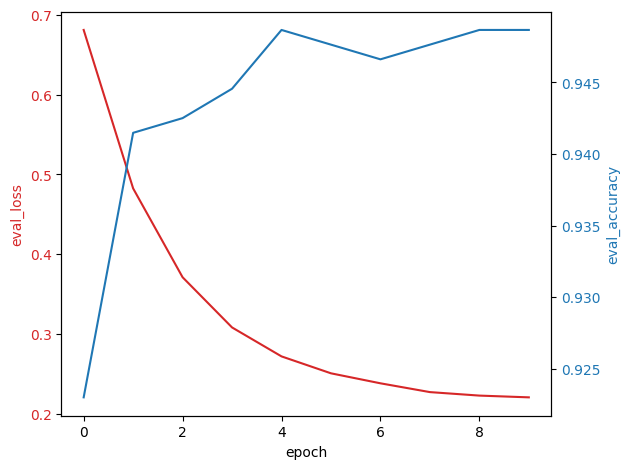

In [71]:
# plot eval loss and accuracy in the same plot with two y axis

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('eval_loss', color=color)
ax1.plot(eval_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('eval_accuracy', color=color)
ax2.plot(eval_accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()
